# 02807 - Week 9 Exercises:  More practice with Spark

In this exercise session you will continue practicing with PySpark in local mode on a Colab enviroment. 

Credits to [Tiziano Piccardi](http://piccardi.me/) for this notebook. You can find a link  with solutions to the exercises at the end of the notebook.

# Learning objectives:

* Getting more practice with PySpark
* Caching data


### Setup

Let's setup Spark on your Colab environment.  Run the cell below!

In [24]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u272-b10-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


Now we authenticate a Google Drive client to download the file we will be processing in our Spark job.

**Make sure to follow the interactive instructions.**

In [25]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [26]:
id='1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('Bombing_Operations.json.gz')

id='14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl'
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile('Aircraft_Glossary.json.gz')  

If you executed the cells above, you should be able to see the files *Bombing_Operations.json.gz* and *Aircraft_Glossary.json.gz* under the "Files" tab on the left panel.

In [27]:
# Let's import the libraries we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

Let's initialize the Spark context.


In [28]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

ValueError: ignored

You can easily check the current version and get the link of the web interface. In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [29]:
spark

If you are running this Colab on the Google hosted runtime, the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [32]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-10-30 15:28:18--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.215.242.209, 3.214.245.1, 52.71.209.190, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.215.242.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.13M  39.3MB/s    in 0.3s    

2020-10-30 15:28:18 (39.3 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ngrok                   
https://ccdc9cb58fa9.ngrok.io


# Vietnam War

**Pres. Johnson**: _What do you think about this Vietnam thing? I’d like to hear you talk a little bit._

**Sen. Russell**: _Well, frankly, Mr. President, it’s the damn worse mess that I ever saw, and I don’t like to brag and I never have been right many times in my life, but I knew that we were going to get into this sort of mess when we went in there._

May 27, 1964

![banner](https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/banner.jpg)

----

The Vietnam War, also known as the Second Indochina War, and in Vietnam as the Resistance War Against America or simply the American War, was a conflict that occurred in Vietnam, Laos, and Cambodia from 1 November 1955 to the fall of Saigon on 30 April 1975. It was the second of the Indochina Wars and was officially fought between North Vietnam and the government of South Vietnam.

**The dataset describes all the air force operation in during the Vietnam War.**

**Bombing_Operations** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/1L6pCQkldvdBoaEhRFzL0VnrggEFvqON4/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- ContryFlyingMission: _Country_
- MissionDate: _Date of the mission_
- OperationSupported: _Supported War operation_ (example: [Operation Rolling Thunder](https://en.wikipedia.org/wiki/Operation_Rolling_Thunder))
- PeriodOfDay: _Day or night_
- TakeoffLocation: _Take off airport_
- TimeOnTarget
- WeaponType
- WeaponsLoadedWeight

**Aircraft_Glossary** [Get the dataset here](https://drive.google.com/a/epfl.ch/file/d/14dyBmcTBA32uXPxDbqr0bFDIzGxMTWwl/view?usp=sharing)

- AirCraft: _Aircraft model (example: EC-47)_
- AirCraftName
- AirCraftType

**Dataset Information:**

THOR is a painstakingly cultivated database of historic aerial bombings from World War I through Vietnam. THOR has already proven useful in finding unexploded ordnance in Southeast Asia and improving Air Force combat tactics:
https://www.kaggle.com/usaf/vietnam-war-bombing-operations

Load the datasets:

In [33]:
# your code goes here
# unzip
!gunzip Aircraft_Glossary.json.gz
!gunzip Bombing_Operations.json.gz

gzip: Aircraft_Glossary.json already exists; do you wish to overwrite (y or n)? y
gzip: Bombing_Operations.json already exists; do you wish to overwrite (y or n)? y


In [34]:
# load json
Aircraft_Glossary = spark.read.json('Aircraft_Glossary.json')
Bombing_Operations = spark.read.json('Bombing_Operations.json')

Check the schema:

In [35]:
# your code goes here
Aircraft_Glossary.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- AirCraftName: string (nullable = true)
 |-- AirCraftType: string (nullable = true)



In [36]:
# your code goes here
Bombing_Operations.printSchema()

root
 |-- AirCraft: string (nullable = true)
 |-- ContryFlyingMission: string (nullable = true)
 |-- MissionDate: string (nullable = true)
 |-- OperationSupported: string (nullable = true)
 |-- PeriodOfDay: string (nullable = true)
 |-- TakeoffLocation: string (nullable = true)
 |-- TargetCountry: string (nullable = true)
 |-- TimeOnTarget: double (nullable = true)
 |-- WeaponType: string (nullable = true)
 |-- WeaponsLoadedWeight: long (nullable = true)



Get a sample with `take()`:

In [37]:
# your code goes here
Aircraft_Glossary.take(10)

[Row(AirCraft='A-1', AirCraftName='Douglas A-1 Skyraider', AirCraftType='Fighter Jet'),
 Row(AirCraft='A-26', AirCraftName='Douglas A-26 Invader', AirCraftType='Light Bomber'),
 Row(AirCraft='A-37', AirCraftName='Cessna A-37 Dragonfly', AirCraftType='Light ground-attack aircraft'),
 Row(AirCraft='A-4', AirCraftName='McDonnell Douglas A-4 Skyhawk', AirCraftType='Fighter Jet'),
 Row(AirCraft='A-5', AirCraftName='North American A-5 Vigilante', AirCraftType='Bomber Jet'),
 Row(AirCraft='A-6', AirCraftName='Grumman A-6 Intruder', AirCraftType='Attack Aircraft'),
 Row(AirCraft='A-7', AirCraftName='LTV A-7 Corsair II', AirCraftType='Attack Aircraft'),
 Row(AirCraft='AC-119', AirCraftName='Fairchild AC-119 Shadow or Stinger', AirCraftType='Military Transport aircraft'),
 Row(AirCraft='AC-123', AirCraftName='Fairchild C-123 Provider ', AirCraftType='Military Transport aircraft'),
 Row(AirCraft='AC-130', AirCraftName='Lockheed AC-130 Spectre', AirCraftType='Fixed wing ground attack gunship')]

Get a formatted sample with `show()`:

In [38]:
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

In [39]:
print("In total there are {0} operations".format(Bombing_Operations.count()))

In total there are 4400775 operations


## Question 1: Which countries are involved and in how many missions? 

Keywords: `Dataframe API`, `SQL`, `group by`, `sort`

Let's group the missions by `ContryFlyingMission` and count how many records exist:

In [40]:
# your code goes here
mission_record = Bombing_Operations.groupBy('ContryFlyingMission')\
        .agg(count("*").alias("MissionsCount"))\
             .sort(desc("MissionsCount"))
mission_record.show()

+--------------------+-------------+
| ContryFlyingMission|MissionsCount|
+--------------------+-------------+
|UNITED STATES OF ...|      3708997|
|     VIETNAM (SOUTH)|       622013|
|                LAOS|        32777|
|       KOREA (SOUTH)|        24469|
|           AUSTRALIA|        12519|
+--------------------+-------------+



The Dataframe is small enough to be moved to Pandas. Use `toPandas()` to do so.

In [41]:
# your code goes here
# 更美观了
mission_record_pd = mission_record.toPandas()
display(mission_record_pd)

,ContryFlyingMission,MissionsCount
0,UNITED STATES OF AMERICA,3708997
1,VIETNAM (SOUTH),622013
2,LAOS,32777
3,KOREA (SOUTH),24469
4,AUSTRALIA,12519


Let's plot a barchart with the number of missions by country:

Text(0.5, 1.0, 'Number of missions by contry')

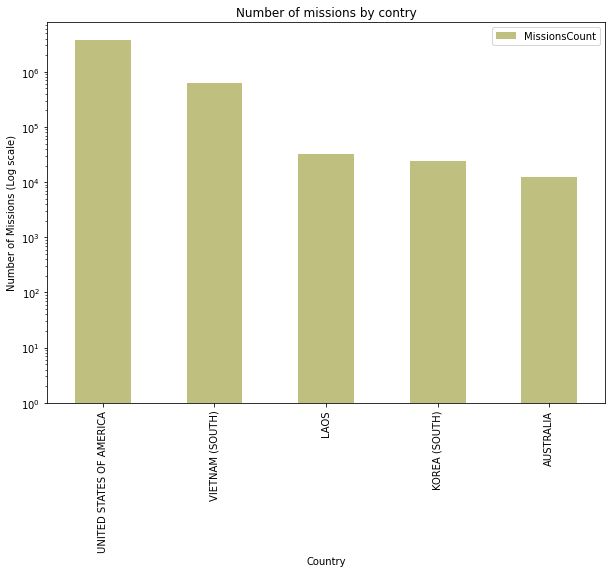

In [43]:
# your code goes here

pl = mission_record_pd.plot(kind="bar",x="ContryFlyingMission", y="MissionsCount", 
              figsize=(10, 7), log=True, alpha=0.5, color="olive")
pl.set_xlabel("Country")
pl.set_ylabel("Number of Missions (Log scale)")
pl.set_title("Number of missions by contry")

----

## Questions 2: Show the number of missions in time for each of the countries involved.

Keywords: `group by`, `parse date`, `plot`

Let's select the relevant columns:

In [23]:
# your code goes here
mission_country = Bombing_Operations.selectExpr(["to_date(MissionDate) as MissionDate", "ContryFlyingMission"])
mission_country.show()

+-----------+--------------------+
|MissionDate| ContryFlyingMission|
+-----------+--------------------+
| 1971-06-05|UNITED STATES OF ...|
| 1972-12-26|UNITED STATES OF ...|
| 1973-07-28|UNITED STATES OF ...|
| 1970-02-02|UNITED STATES OF ...|
| 1970-10-08|     VIETNAM (SOUTH)|
| 1970-11-25|UNITED STATES OF ...|
| 1972-03-08|UNITED STATES OF ...|
| 1971-12-27|UNITED STATES OF ...|
| 1972-05-24|UNITED STATES OF ...|
| 1972-09-12|UNITED STATES OF ...|
| 1974-06-13|UNITED STATES OF ...|
| 1974-12-19|UNITED STATES OF ...|
| 1973-10-24|     VIETNAM (SOUTH)|
| 1974-03-19|     VIETNAM (SOUTH)|
| 1970-05-08|UNITED STATES OF ...|
| 1971-05-12|UNITED STATES OF ...|
| 1971-12-03|UNITED STATES OF ...|
| 1971-12-19|                LAOS|
| 1972-08-18|UNITED STATES OF ...|
| 1972-10-15|UNITED STATES OF ...|
+-----------+--------------------+
only showing top 20 rows



The filed MissionDate is converted to a Python `date` object.

Now we can group by `MissionDate` and `ContryFlyingMission` to get the count:

In [45]:
# your code goes here
mission_count = mission_country.groupBy(['MissionDate', 'ContryFlyingMission'])\
                    .agg(count('*').alias('MissionCount'))\
                    .sort(desc('MissionCount'))
mission_count.show()

+-----------+--------------------+------------+
|MissionDate| ContryFlyingMission|MissionCount|
+-----------+--------------------+------------+
| 1968-06-07|UNITED STATES OF ...|        3832|
| 1968-09-16|UNITED STATES OF ...|        3755|
| 1968-09-18|UNITED STATES OF ...|        3752|
| 1968-09-17|UNITED STATES OF ...|        3706|
| 1968-05-11|UNITED STATES OF ...|        3692|
| 1968-09-14|UNITED STATES OF ...|        3646|
| 1968-06-16|UNITED STATES OF ...|        3639|
| 1968-06-23|UNITED STATES OF ...|        3630|
| 1968-06-11|UNITED STATES OF ...|        3628|
| 1968-09-19|UNITED STATES OF ...|        3614|
| 1968-05-25|UNITED STATES OF ...|        3605|
| 1968-05-22|UNITED STATES OF ...|        3590|
| 1968-06-19|UNITED STATES OF ...|        3582|
| 1968-09-15|UNITED STATES OF ...|        3568|
| 1968-05-13|UNITED STATES OF ...|        3531|
| 1968-05-26|UNITED STATES OF ...|        3530|
| 1968-09-28|UNITED STATES OF ...|        3517|
| 1968-09-08|UNITED STATES OF ...|      

Now we can plot the content with a different series for each country:

In [48]:
# your code goes here
mission_count_pd = mission_count.toPandas()

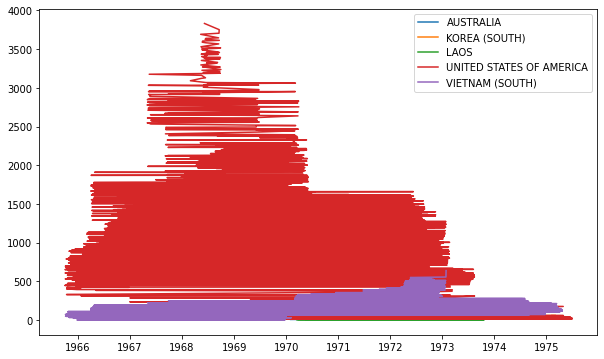

In [51]:
fig = plt.figure(figsize=(10, 6))

# iterate the different groups to create a different series
for country, missions in mission_count_pd.groupby("ContryFlyingMission"): 
    plt.plot(missions["MissionDate"], missions["MissionCount"], label=country)

plt.legend(loc='best')

We can observe how South Vietnam increased its missions starting from 1970. The drop in 1973 is motivated by the [Paris Peace Accords](https://en.wikipedia.org/wiki/Paris_Peace_Accords) that took place on January 27th, 1973, to establish peace in Vietnam and end the war.

----

## Question 3: Who bombed this location?

Keywords: `RDD map reduce` `cache` `save results`

<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/Hanoi_POL1966.jpg">

This picture is the Hanoi POL facility (North Vietnam) burning after it was attacked by the U.S. Air Force on 29 June 1966 in the context of the Rolling Thunder operation. 

We are interested in discovering what was the most common take-off location during that day.

In [52]:
jun_29_operations = Bombing_Operations.where("MissionDate = '1966-06-29' AND TargetCountry='NORTH VIETNAM'")

Which coutries scheduled missions that day?

In [55]:
# your code goes here
mission_count_pd = jun_29_operations.groupBy("ContryFlyingMission").agg(count("*").alias("MissionsCount")).toPandas()
mission_count_pd

,ContryFlyingMission,MissionsCount
0,VIETNAM (SOUTH),6
1,UNITED STATES OF AMERICA,389


Most of the operation that day were performed by USA airplanes.

In [58]:
# your code goes here
mission_count_pd.iloc[1]

ContryFlyingMission    UNITED STATES OF AMERICA
MissionsCount                               389
Name: 1, dtype: object

You can specify to cache the content in memory. Use `cache()` to do so.

In [59]:
# your code goes here
jun_29_operations.cache()

DataFrame[AirCraft: string, ContryFlyingMission: string, MissionDate: string, OperationSupported: string, PeriodOfDay: string, TakeoffLocation: string, TargetCountry: string, TimeOnTarget: double, WeaponType: string, WeaponsLoadedWeight: bigint]

Now you can count the number of rows and move the content to the cache:

In [60]:
# your code goes here
%time jun_29_operations.count()

CPU times: user 1.87 ms, sys: 920 µs, total: 2.79 ms
Wall time: 8.5 s


395

The second time the content is cached and the operation is much faster. Use `%timeit` to see how much improvement we get.

In [61]:
# your code goes here
# 快多了
%time jun_29_operations.count()

CPU times: user 765 µs, sys: 93 µs, total: 858 µs
Wall time: 91.2 ms


395

You can also save the results on a file... Use `write`.

In [62]:
# your code goes here
jun_29_operations.write.mode('overwrite').json("jun_29_operations.json")

... and read from the file:

In [64]:
# your code goes here
df = spark.read.json('jun_29_operations.json')
df.show()

+--------+--------------------+-----------+------------------+-----------+----------------+-------------+------------+--------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay| TakeoffLocation|TargetCountry|TimeOnTarget|    WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+----------------+-------------+------------+--------------+-------------------+
|    RF-4|UNITED STATES OF ...| 1966-06-29|              null|          N|    TAN SON NHUT|NORTH VIETNAM|      1303.0|   PHOTO EQUIP|                 -1|
|     A-4|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          D|          RANGER|NORTH VIETNAM|       450.0|   250LB MK-81|                 -1|
|     A-4|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          D|   CONSTELLATION|NORTH VIETNAM|       450.0|5.0IN HEAT RKT|                 -1|
|   F-105|UNITED STATES OF ...| 1966-06-29|      ROLLING THUN|          D|  

Finally, group the records by take-off location, and show the mission counts for each location, in descending order.

In [66]:
# your code goes here
tmp = df.groupBy('TakeoffLocation').agg(count('*').alias('counts')).sort(desc('counts'))
tmp.show()

+----------------+------+
| TakeoffLocation|counts|
+----------------+------+
|   CONSTELLATION|    87|
|          TAKHLI|    56|
|           KORAT|    55|
|        UDORN AB|    44|
|         UBON AB|    44|
|          DANANG|    35|
|          RANGER|    35|
|    TAN SON NHUT|    26|
|HANCOCK (CVA-19)|    10|
|    CAM RANH BAY|     2|
|         CUBI PT|     1|
+----------------+------+



<img style="float: right;" src="https://raw.githubusercontent.com/epfl-ada/2019/c17af0d3c73f11cb083717b7408fedd86245dc4d/Tutorials/04%20-%20Scaling%20Up/img/USS_Constellation.jpg">


That day the most common take-off location was the ship USS Constellation (CV-64). We cannot univocally identify one take off location, but we can reduce the possible candidates. Next steps: explore TimeOnTarget feature.

_USS Constellation (CV-64), a Kitty Hawk-class supercarrier, was the third ship of the United States Navy to be named in honor of the "new constellation of stars" on the flag of the United States. One of the fastest ships in the Navy, as proven by her victory during a battlegroup race held in 1985, she was nicknamed "Connie" by her crew and officially as "America's Flagship"._

----

## Questions 4: What is the most used aircraft type during the Vietnam war (number of missions)?

Keywords: `join` `group by`

Let's check the content of `Aircraft_Glossary`. Have a look at it using `show`.

In [68]:
# your code goes here
Aircraft_Glossary.show()

+--------+--------------------+--------------------+
|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+--------------------+
|     A-1|Douglas A-1 Skyra...|         Fighter Jet|
|    A-26|Douglas A-26 Invader|        Light Bomber|
|    A-37|Cessna A-37 Drago...|Light ground-atta...|
|     A-4|McDonnell Douglas...|         Fighter Jet|
|     A-5|North American A-...|          Bomber Jet|
|     A-6|Grumman A-6 Intruder|     Attack Aircraft|
|     A-7|  LTV A-7 Corsair II|     Attack Aircraft|
|  AC-119|Fairchild AC-119 ...|Military Transpor...|
|  AC-123|Fairchild C-123 P...|Military Transpor...|
|  AC-130|Lockheed AC-130 S...|Fixed wing ground...|
|   AC-47|Douglas AC-47 Spooky|Ground attack air...|
|    AH-1| Bell AH-1 HueyCobra|          Helicopter|
|     B-1| Rockwell B-1 Lancer|Heavy strategic b...|
|    B-52| B-52 Stratofortress|    Strategic bomber|
|    B-57|Martin B-57 Canberra|     Tactical Bomber|
|    B-66|Douglas B-66 Dest...|        Light B

We are interested in the filed `AirCraftType`. Have a look at it using `show`.

In [69]:
# your code goes here
Aircraft_Glossary.select('AirCraftType').show()

+--------------------+
|        AirCraftType|
+--------------------+
|         Fighter Jet|
|        Light Bomber|
|Light ground-atta...|
|         Fighter Jet|
|          Bomber Jet|
|     Attack Aircraft|
|     Attack Aircraft|
|Military Transpor...|
|Military Transpor...|
|Fixed wing ground...|
|Ground attack air...|
|          Helicopter|
|Heavy strategic b...|
|    Strategic bomber|
|     Tactical Bomber|
|        Light Bomber|
|           Transport|
|           Transport|
|Military Transpor...|
|Military Transpor...|
+--------------------+
only showing top 20 rows



Join the two dataframes on the column `AirCraft` of both dataframes. Use `join` to create a dataframe `missions_joines`:

In [71]:
# your code goes here
missions_joined = Bombing_Operations.join(Aircraft_Glossary, Bombing_Operations.AirCraft == Aircraft_Glossary.AirCraft)
missions_joined.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+--------+--------------------+--------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|AirCraft|        AirCraftName|        AirCraftType|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+--------+--------------------+--------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              null|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                null|                  0|   EC-47|Douglas C-47 Skyt...|Military Transpor...|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              null|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                null|                  0|  

We can select only the field we are interested in:

In [72]:
missions_aircrafts = missions_joined.select("AirCraftType")
missions_aircrafts.show(5)

+--------------------+
|        AirCraftType|
+--------------------+
|Military Transpor...|
|Military Transpor...|
|  Fighter bomber jet|
|         Fighter Jet|
|Light ground-atta...|
+--------------------+
only showing top 5 rows



And finally we can group by `AirCraftType` and count:

In [73]:
# your code goes here
missions_aircrafts.groupBy("AirCraftType").agg(count("*").alias("MissionsCount"))\
                  .sort(desc("MissionsCount"))\
                  .show()

+--------------------+-------------+
|        AirCraftType|MissionsCount|
+--------------------+-------------+
|  Fighter Jet Bomber|      1073126|
|         Fighter Jet|       882594|
|  Jet Fighter Bomber|       451385|
|     Attack Aircraft|       315246|
|Light ground-atta...|       267457|
|  Fighter bomber jet|       242231|
|Military Transpor...|       228426|
|  Utility Helicopter|       146653|
|    Strategic bomber|        99100|
|     Tactical Bomber|        82219|
|Observation Aircraft|        81820|
|Fixed wing ground...|        75058|
|Ground attack air...|        73843|
|Carrier-based Fig...|        58691|
|   Training Aircraft|        48435|
|       Light fighter|        39999|
|        Light Bomber|        39262|
|Light Tactical Bo...|        34738|
| Light Utility Plane|        28582|
|Observation/ Ligh...|        24491|
+--------------------+-------------+
only showing top 20 rows



The aircrafts of type `Fighter Jet Bomber` participated in most of the missions in the Vietnam war.

Note: This dataset would require further cleaning and normalization. See `Fighter Jet Bomber`, `Jet Fighter Bomber`, `Fighter bomber jet`

# Solutions

You can find the solutions here:

[Solutions](https://github.com/epfl-ada/2019/blob/master/Tutorials/04%20-%20Scaling%20Up/PySpark.ipynb)